# Import

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import pandas as pd
import numpy as np
#import seaborn as sns
import seaborn as sns
sns.set_theme(style="dark")
import matplotlib.pyplot as plt
import os
from shutil import copyfile
#import splitfolders

In [ ]:
from neuralart.data import *

# Download Chan data

# Get Chan data

In [ ]:
chan_csv_path = "../../raw_data/wikiart/csv_chan"
chan_image_path= "../../raw_data/wikiart/dataset_chan"
output_path = "../../raw_data/wikiart"
dataset_dir_name = 'dataset'

In [ ]:
data_full = get_data(chan_csv_path, chan_image_path, rm_image_duplicate=False)
# save_csv(data_full, output_path, 'data_full.csv')
data_full.shape

In [ ]:
data = get_data(chan_csv_path, chan_image_path, rm_image_duplicate=True)
# save_csv(data, output_path, 'data.csv')
data.shape

# Merge Chan data

In [ ]:
merge_mov_1={'name': 'merge_mov-1',
            'merging':{'abstract_expressionism': 'abstract', 'action_painting': 'abstract', 'analytical_cubism': 'cubism', 
                       'art_nouveau_modern': None, 'baroque': None, 'color_field_painting': 'color_field_painting', 
                       'contemporary_realism': None, 'cubism': 'cubism', 'early_renaissance': 'renaissance', 'expressionism': 'expressionism',
                       'fauvism': None, 'high_renaissance': 'renaissance', 'impressionism': 'impressionism',
                       'mannerism_late_renaissance': None, 'minimalism': None, 'naive_art_primitivism': None,
                       'new_realism': None, 'northern_renaissance': 'renaissance', 'pointillism': None, 'pop_art': None,
                       'post_impressionism': None, 'realism': 'realism', 'rococo': None, 'romanticism': 'romanticism',
                       'symbolism': None, 'synthetic_cubism': 'cubism', 'ukiyo_e': None}}

In [ ]:
data_sample = get_dataset(data, target="movement", class_=merge_mov_1,random_state=123, keep_genre=True, output_path=output_path)


# Create data directory

In [ ]:
create_dataset_directory(data_sample, chan_image_path, output_path, 'wikiart-movement-genre_True-class_8-merge_mov-1', flat=False)


In [ ]:
input_dir = os.path.join(output_path,"wikiart-movement-genre_True-class_8-merge_mov-1")
output_dir = os.path.join(output_path,"train_val_test_True_all")
csv_path = os.path.join(output_path,"wikiart-movement-genre_True-class_8-merge_mov-1.csv")

In [ ]:
get_train_val_test_directory(output_dir, input_dir=input_dir,
                                 csv_path=csv_path,
                                 save_csv=True,
                                 train_ratio=0.8,
                                 val_ratio=0.1,
                                 test_ratio=0.1,
                                 seed=1337)

# Data Visualization

In [14]:
data = pd.read_csv("wikiart-movement-genre_True-class_8-merge_mov-1_split.csv")

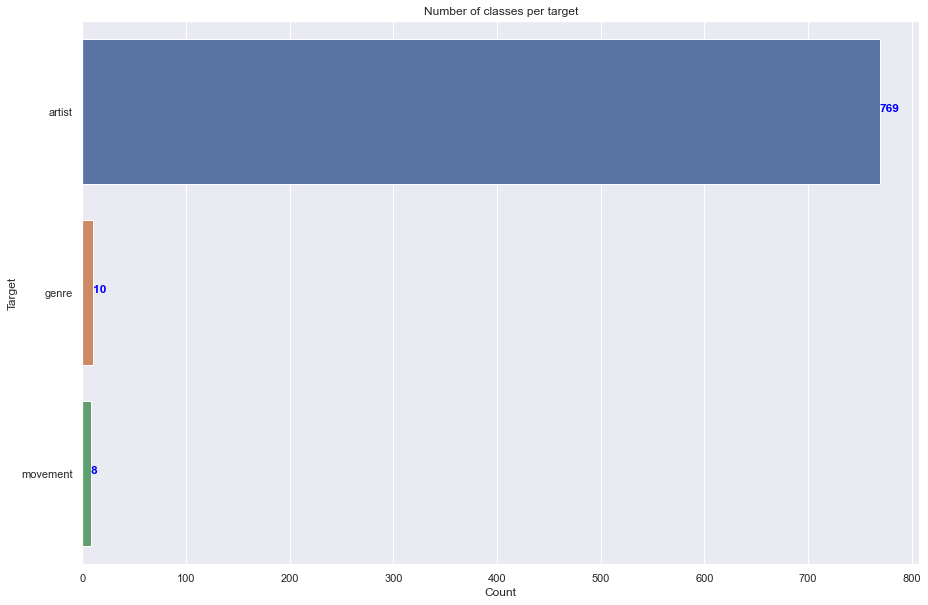

In [15]:
col = ['artist','genre','movement']

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(y=data[col].nunique().index, 
            x=data[col].nunique().values,
            order=data[col].nunique().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data[col].nunique().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of classes per target");
ax.set_xlabel("Count");
ax.set_ylabel("Target");

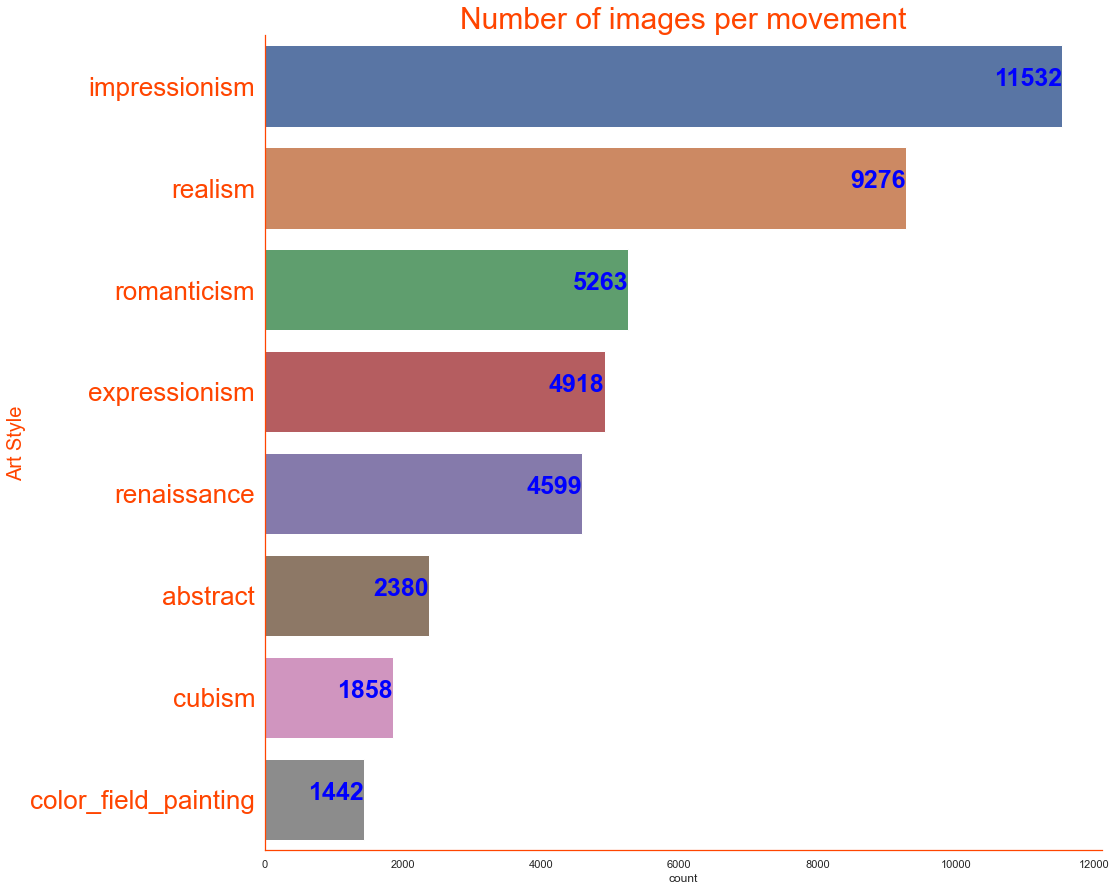

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,1,figsize=(15,15));
sns.countplot(data=data, y="movement", 
              order = data['movement'].value_counts().index,
              ax=ax);
sns.despine()

for i, v in enumerate(data["movement"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold',fontsize='25',horizontalalignment='right')
    
ax.set_title("Number of images per movement",color="#FF4500",size=30);
ax.set_ylabel("Movement (Art Style)");
ax.spines["bottom"].set_color("#FF4500")
ax.spines["left"].set_color("#FF4500")
ax.tick_params(axis='y', colors='#FF4500',labelsize=26)
ax.set_ylabel("Art Style",
                  loc='center',
                  rotation='vertical',
                  color="#FF4500",size=20)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

fig.savefig('class_split_2.png',bbox_inches='tight')

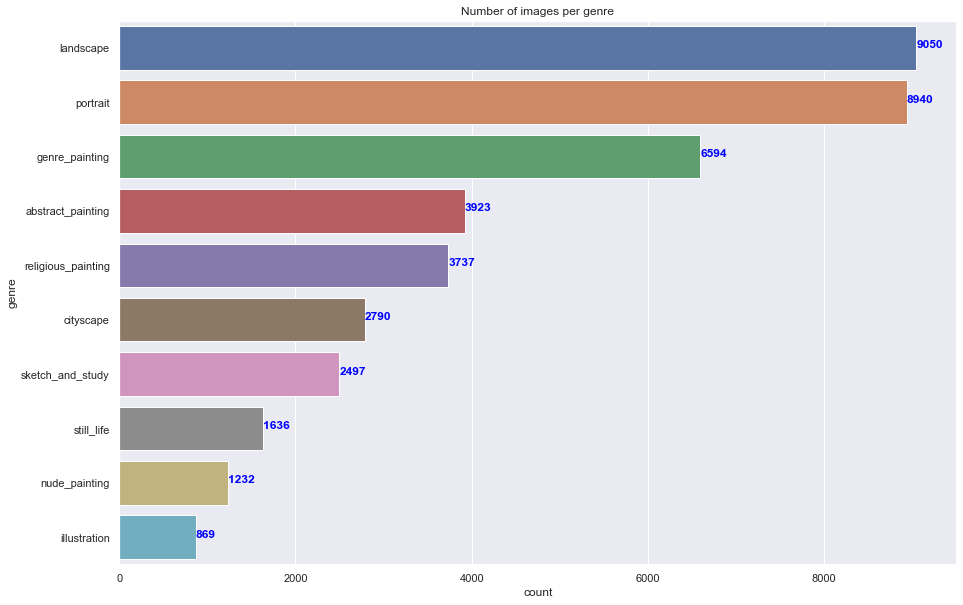

In [12]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data, y="genre", 
              order = data['genre'].value_counts().index,
              ax=ax);

for i, v in enumerate(data["genre"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images per genre");

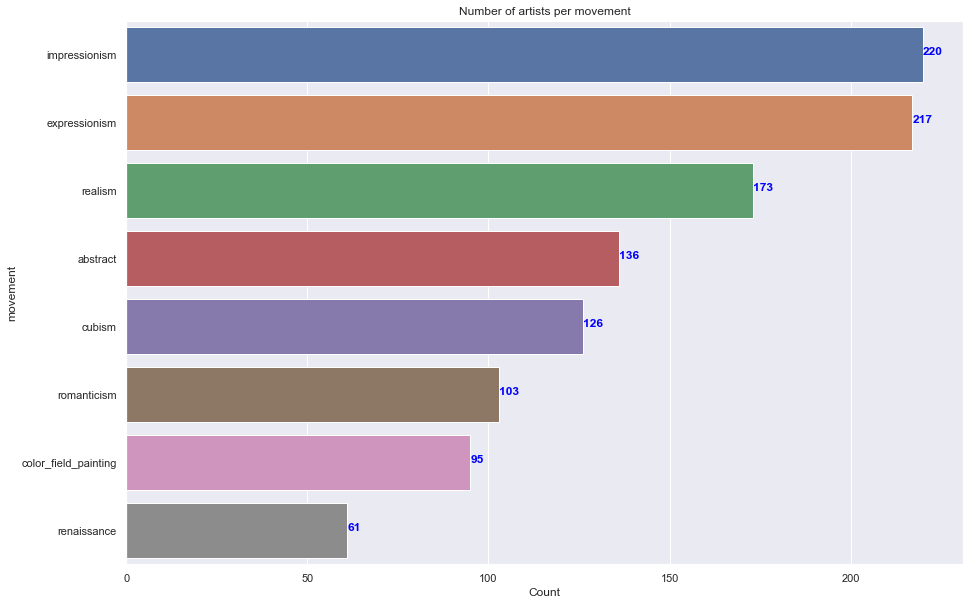

In [13]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.barplot(y=data.groupby("movement").artist.nunique().index, 
            x=data.groupby("movement").artist.nunique().values,
            order=data.groupby("movement").artist.nunique().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data.groupby("movement").artist.nunique().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of artists per movement");
ax.set_xlabel("Count");